In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torchvision import transforms
from torch.utils.data import DataLoader

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [4]:
sites = {
    "SO2",
    # "ES-LTERA",
}
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 516
Num validation 111
Num test 111


In [5]:
# Compute data mean and std for chennels
train_patches.set_transform(lambda x, y: (x[:3, :, :], y[:3, :, :]))
loader = DataLoader(train_patches, batch_size=256)
channel_means = torch.zeros((3, 1, 1))
channel_std = torch.zeros((3, 1, 1))
hr_channel_means = torch.zeros((3, 1, 1))
hr_channel_std = torch.zeros((3, 1, 1))

for low_res, high_res in loader:
    channel_means += torch.mean(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    channel_std += torch.std(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_means += torch.mean(high_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_std += torch.std(high_res, (0, 2, 3), keepdim=True).squeeze(0)

channel_means /= len(loader)
channel_std /= len(loader)
hr_channel_means /= len(loader)
hr_channel_std /= len(loader)

In [6]:
channel_means, hr_channel_means

(tensor([[[0.0480]],
 
         [[0.0763]],
 
         [[0.0792]]]),
 tensor([[[0.0477]],
 
         [[0.0758]],
 
         [[0.0793]]]))

In [7]:
channel_std, hr_channel_std

(tensor([[[0.0262]],
 
         [[0.0334]],
 
         [[0.0517]]]),
 tensor([[[0.0260]],
 
         [[0.0332]],
 
         [[0.0517]]]))

In [8]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]
    x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)
    y_channel_max = y.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    y_channel_min = y.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

    x = (x - x_channel_min) / (x_channel_max - x_channel_min)
    y = (y - y_channel_min) / (y_channel_max - y_channel_min)

    return x, y


def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    # x = (x - channel_means) / channel_std
    # y = (y - hr_channel_means) / hr_channel_std

    return x, y

In [9]:
train_patches.set_transform(image_transform)

In [10]:
train_loader = DataLoader(train_patches, batch_size=2)

In [11]:
(low_res, high_res) = next(train_loader.__iter__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


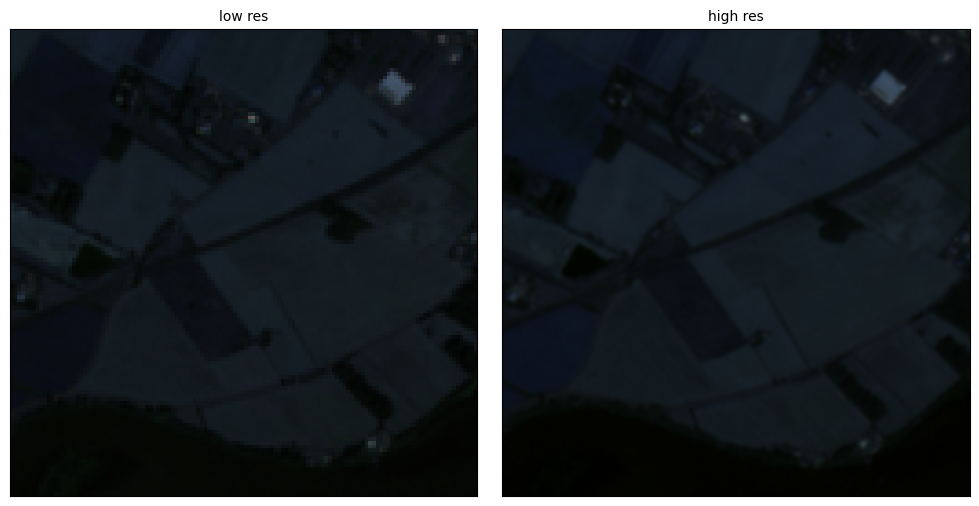

In [12]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [14]:
device

device(type='cuda')

In [15]:
model = SRResNet(scaling_factor=2)

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)

In [46]:
1 / 0

ZeroDivisionError: division by zero

In [47]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [17]:
model = model.to(device)
model = model.train()

In [18]:
vgg = TruncatedVGG19().to(device)
vgg = vgg.eval()

In [19]:
NUM_EPOCHS = 50

In [20]:
losses = []
epoch_losses = []

In [21]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    epoch_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch)
        low_vgg = vgg(out)
        high_vgg = vgg(high_res_batch).detach()
        loss = criterion(low_vgg, high_vgg)
        loss.backward()
        optimizer.step()

        # Collect data
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix(epoch=epoch, batch_loss=loss.item())

    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch: {epoch} / loss: {epoch_loss:.5f}")

100%|████████████████████████████████████| 32/32 [00:31<00:00,  1.01it/s, batch_loss=0.024, epoch=0]


Epoch: 0 / loss: 0.03085


100%|███████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s, batch_loss=0.0243, epoch=1]


Epoch: 1 / loss: 0.02343


100%|███████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0201, epoch=2]


Epoch: 2 / loss: 0.02107


100%|███████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0183, epoch=3]


Epoch: 3 / loss: 0.01837


100%|███████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0155, epoch=4]


Epoch: 4 / loss: 0.01638


100%|████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.012, epoch=5]


Epoch: 5 / loss: 0.01290


100%|███████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0115, epoch=6]


Epoch: 6 / loss: 0.00936


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00667, epoch=7]


Epoch: 7 / loss: 0.00757


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00542, epoch=8]


Epoch: 8 / loss: 0.00595


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00764, epoch=9]


Epoch: 9 / loss: 0.00528


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00538, epoch=10]


Epoch: 10 / loss: 0.00527


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00325, epoch=11]


Epoch: 11 / loss: 0.00462


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00413, epoch=12]


Epoch: 12 / loss: 0.00426


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00606, epoch=13]


Epoch: 13 / loss: 0.00389


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00358, epoch=14]


Epoch: 14 / loss: 0.00374


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0037, epoch=15]


Epoch: 15 / loss: 0.00375


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00334, epoch=16]


Epoch: 16 / loss: 0.00368


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00365, epoch=17]


Epoch: 17 / loss: 0.00341


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00344, epoch=18]


Epoch: 18 / loss: 0.00376


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00348, epoch=19]


Epoch: 19 / loss: 0.00362


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00274, epoch=20]


Epoch: 20 / loss: 0.00338


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00233, epoch=21]


Epoch: 21 / loss: 0.00299


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00364, epoch=22]


Epoch: 22 / loss: 0.00327


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00299, epoch=23]


Epoch: 23 / loss: 0.00328


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00292, epoch=24]


Epoch: 24 / loss: 0.00301


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00336, epoch=25]


Epoch: 25 / loss: 0.00319


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00317, epoch=26]


Epoch: 26 / loss: 0.00291


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00285, epoch=27]


Epoch: 27 / loss: 0.00309


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00252, epoch=28]


Epoch: 28 / loss: 0.00295


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00229, epoch=29]


Epoch: 29 / loss: 0.00267


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00233, epoch=30]


Epoch: 30 / loss: 0.00282


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00216, epoch=31]


Epoch: 31 / loss: 0.00276


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0023, epoch=32]


Epoch: 32 / loss: 0.00256


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00253, epoch=33]


Epoch: 33 / loss: 0.00275


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00244, epoch=34]


Epoch: 34 / loss: 0.00276


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00242, epoch=35]


Epoch: 35 / loss: 0.00239


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00332, epoch=36]


Epoch: 36 / loss: 0.00258


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00311, epoch=37]


Epoch: 37 / loss: 0.00240


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00171, epoch=38]


Epoch: 38 / loss: 0.00228


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00251, epoch=39]


Epoch: 39 / loss: 0.00232


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00236, epoch=40]


Epoch: 40 / loss: 0.00255


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00229, epoch=41]


Epoch: 41 / loss: 0.00219


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00216, epoch=42]


Epoch: 42 / loss: 0.00233


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00199, epoch=43]


Epoch: 43 / loss: 0.00218


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00232, epoch=44]


Epoch: 44 / loss: 0.00219


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00208, epoch=45]


Epoch: 45 / loss: 0.00218


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00191, epoch=46]


Epoch: 46 / loss: 0.00205


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00208, epoch=47]


Epoch: 47 / loss: 0.00196


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00275, epoch=48]


Epoch: 48 / loss: 0.00207


100%|█████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00221, epoch=49]

Epoch: 49 / loss: 0.00212


In [22]:
len(epoch_losses)

50

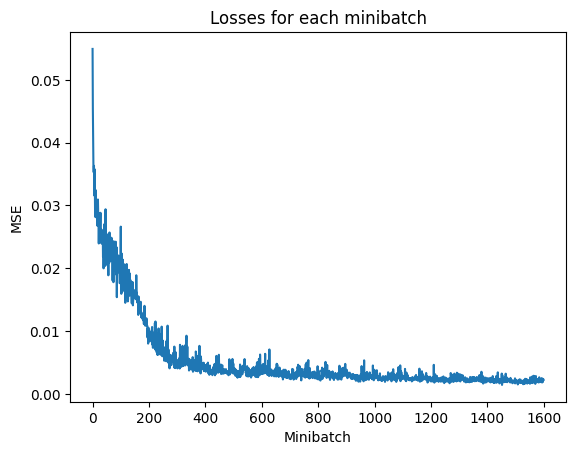

In [23]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()

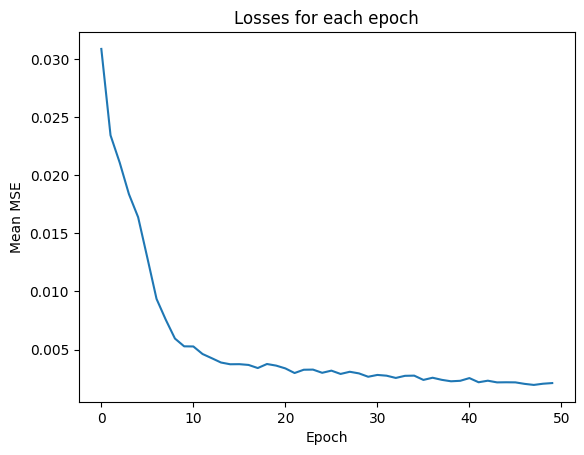

In [24]:
plt.plot(epoch_losses)
plt.title("Losses for each epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.show()

In [ ]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
save_file = RESULTS_DIR / "superres300epochs_results.pkl"

In [25]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

In [26]:
model = model.to("cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


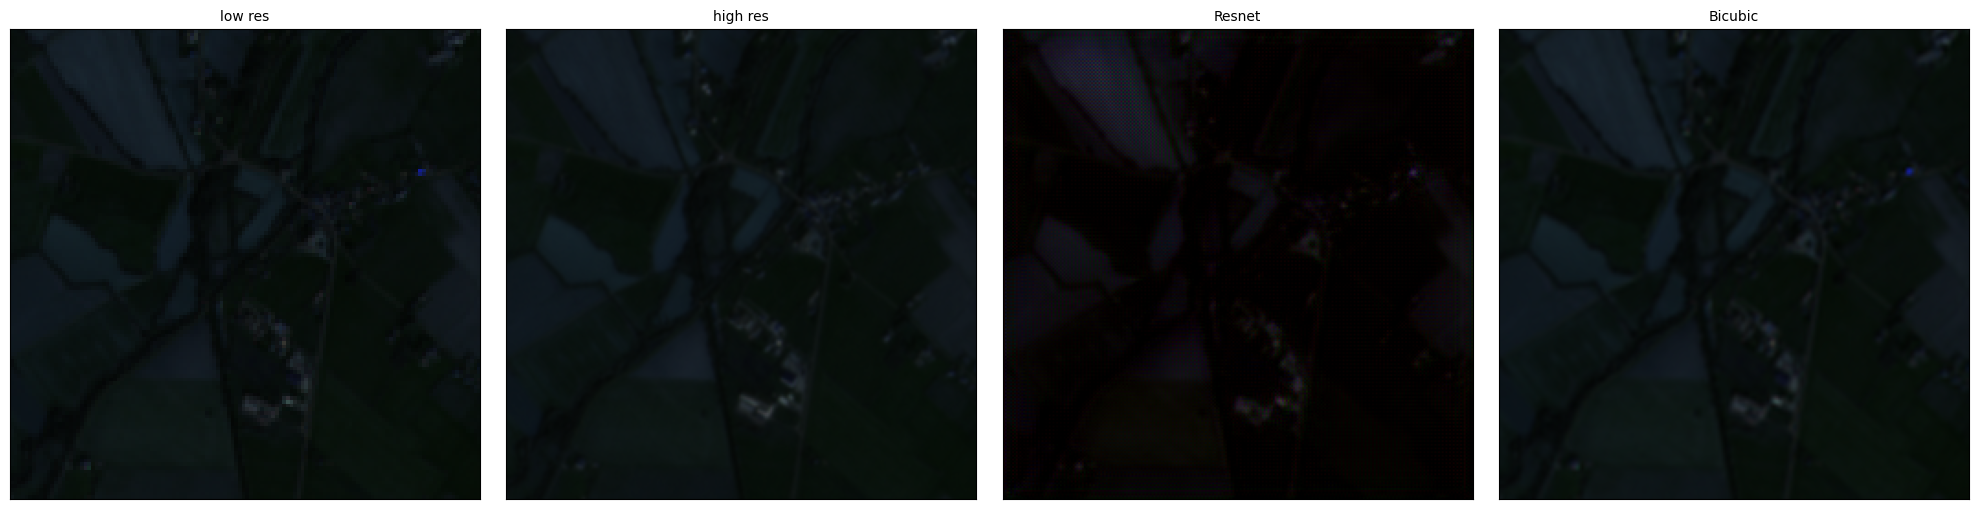

In [27]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
bicubic_out = interpolate(
    low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic"
).float()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
        bicubic_out[0].permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [28]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


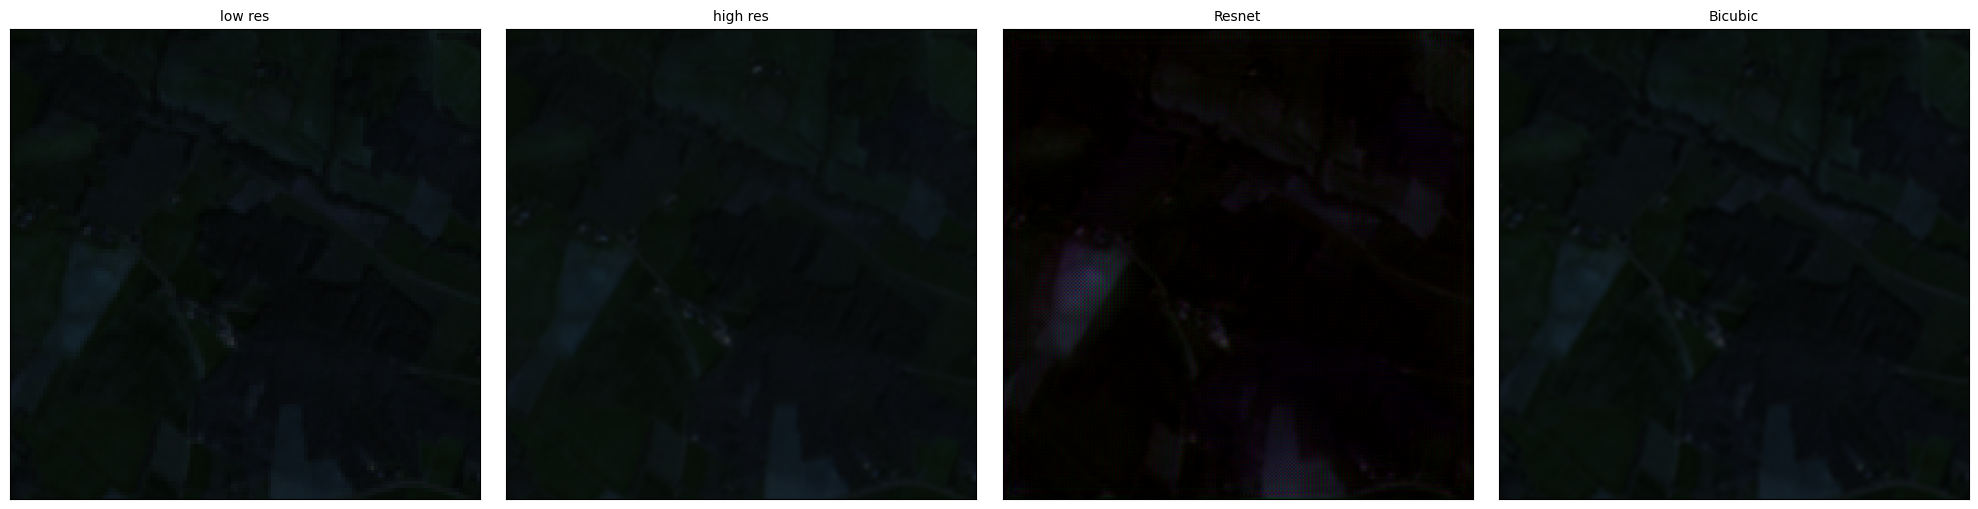

In [29]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
bicubic_out = interpolate(
    low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic"
).float()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
        bicubic_out[0].permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [1]:
print("hello world")

hello world
